In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import h5py
import os
import re
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
scatterStyles={"s":100,"marker":"x","linewidth":3.0}
np.seterr(divide='ignore',invalid='ignore')
pass

In [2]:
def addOrderParameter(filename, id, type, speciesIDs, speciesCoefficients):
    print "Adding order parameters to %s"%filename
    fp = h5py.File(filename, "r+")
    if "OrderParameters" not in fp.keys():
        opg = fp.create_group("/OrderParameters/%07d"%id)
        opg.attrs.create("ID", id, dtype=np.uint32)
        opg.attrs.create("Type", type, dtype=np.uint32)
        d1=opg.create_dataset("SpeciesIDs", (len(speciesIDs),), dtype=np.uint32)
        d1[:]=np.array(speciesIDs)
        d2=opg.create_dataset("SpeciesCoefficients", (len(speciesIDs),), dtype=double)
        d2[:]=np.array(speciesCoefficients)
    else:
        print "ERROR: file already has order parameters"
    fp.close()
    


### Execute with fpt tracking

In [ ]:
%%bash
dirname=data/1
filename=${dirname}/bimolecular_with_fpt.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} bimolecular_with_fpt.sbml
lm_setp ${filename} writeInterval=1e3 maxTime=1e4 "fptTrackingList=2,5"

In [5]:
%%bash
dirname=data/1
filename=${dirname}/bimolecular_with_fpt.lm
lmes -r 1-48 -f ${filename} -gr 0 -c 4 -sl lm::cme::GillespieDSolver > ${filename}.log
# lmes -r 1-48 -f ${filename} -gr 0 -c 4 -sl lm::avx::GillespieDSolverAVX > ${filename}.log

lm_sbml_import v2018.02 build 
Copyright (C) 2012-2018 Roberts Group, Johns Hopkins University.
Copyright (C) 2008-2012 Luthey-Schulten Group, University of Illinois at Urbana-Champaign.


2018-04-05 22:30:28) SBML L3V1 Importer processing document.
2018-04-05 22:30:28) Processing 1 compartments.
2018-04-05 22:30:28) Added compartment (0) V: 1.000000e+00 L
2018-04-05 22:30:28) Processing 6 species.
2018-04-05 22:30:28) Added species (0) a with initial count: 500
2018-04-05 22:30:28) Added species (1) b with initial count: 500
2018-04-05 22:30:28) Added species (2) c with initial count: 500
2018-04-05 22:30:28) Added species (3) d with initial count: 50
2018-04-05 22:30:28) Added species (4) e with initial count: 50
2018-04-05 22:30:28) Added species (5) f with initial count: 50
2018-04-05 22:30:28) Processing 4 reactions.
2018-04-05 22:30:28) Matched kinetic formula in reaction  (0) to SecondOrderPropensity: [0.002 * a * b] == [k1 * x1 * x2]
2018-04-05 22:30:28) Matched kinetic formula

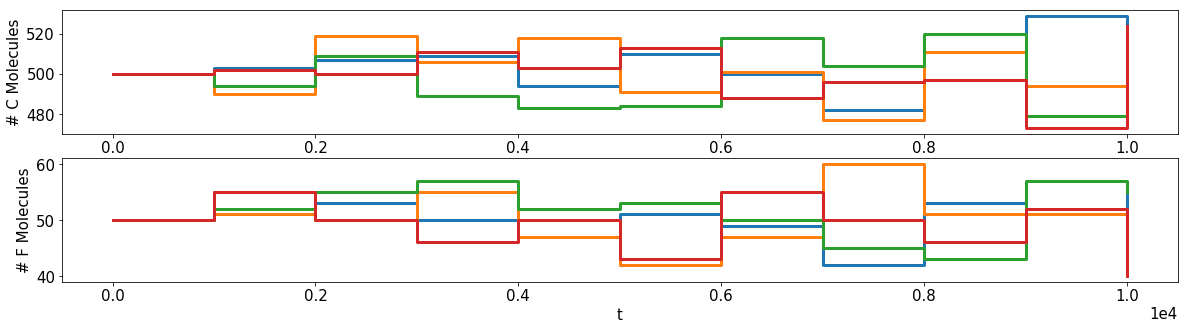

In [2]:
# Plot the time series for a few replicates.
dirname="data/1"
filename="%s/bimolecular_with_fpt.lm"%dirname
fp = h5py.File(filename, "r")
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})

ax0,ax1 = plt.subplot(2,1,1),plt.subplot(2,1,2)
for replicate in (1,2,3,4):
    counts=fp["/Simulations/%07d/SpeciesCounts"%replicate]
    times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate]
    plt.sca(ax0)
    plt.step(times,counts[:,2], **stepStyles)
    plt.sca(ax1)
    plt.step(times,counts[:,5], **stepStyles)
plt.sca(ax0)
xlabel('t'); ylabel('# C Molecules')
plt.sca(ax1)
xlabel('t'); ylabel('# F Molecules')
pass

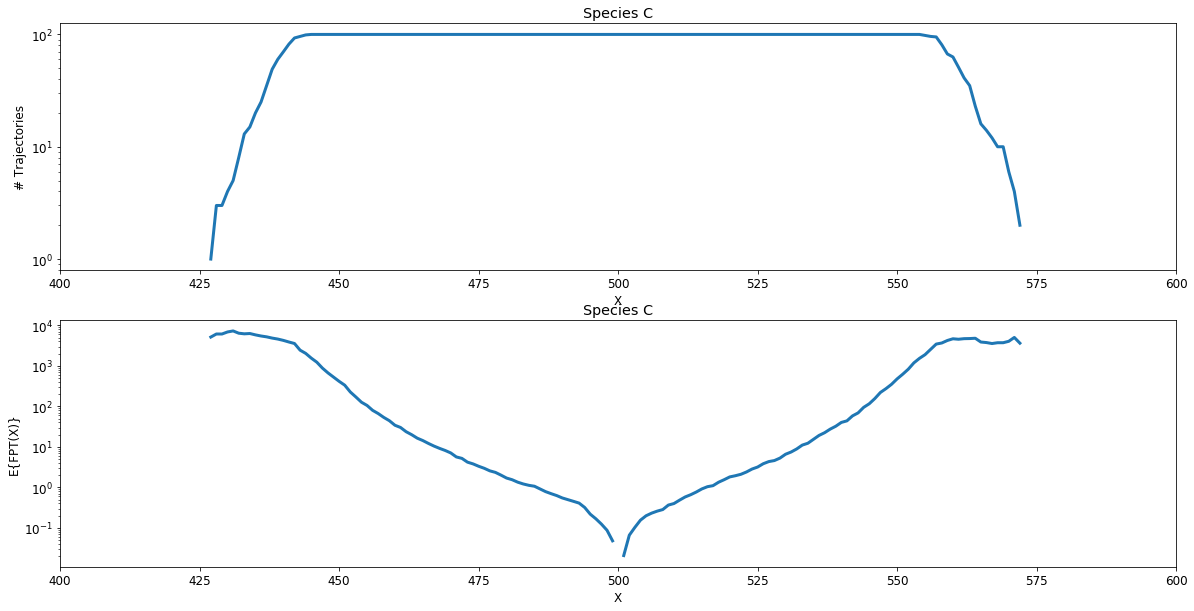

In [2]:
# Plot the mean first passage times for species 2.
dirname="data/1"
filename="%s/bimolecular_with_fpt.lm"%dirname
fp = h5py.File(filename, "r")
replicates=fp["/Simulations"].keys()
counts=None
times=None
allCounts = np.zeros((1001,), dtype=double)
allTimes = np.zeros((1001,), dtype=double)
for replicate in replicates:
    counts=np.array(fp["/Simulations/%s/FirstPassageTimes/02/Counts"%replicate], dtype=double)
    times=np.array(fp["/Simulations/%s/FirstPassageTimes/02/Times"%replicate], dtype=double)
    start = int(counts[0])
    end = start+counts.shape[0]
    allCounts[start:end] += 1    
    allTimes[start:end] += times
allTimes /= allCounts
matplotlib.rcParams.update({'font.size': 12, "figure.figsize": (20,10)})
ax=plt.subplot(2,1,1)
plt.plot(np.arange(0,len(allCounts), dtype=double),allCounts, **plotStyles)
ax.set_yscale('log'); xlim([400,600]); xlabel('X'); ylabel('# Trajectories'); title("Species C")
ax=plt.subplot(2,1,2)
plt.plot(np.arange(0,len(allCounts), dtype=double),allTimes, **plotStyles)
ax.set_yscale('log'); xlim([400,600]); xlabel('X'); ylabel('E{FPT(X)}'); title("Species C")
pass

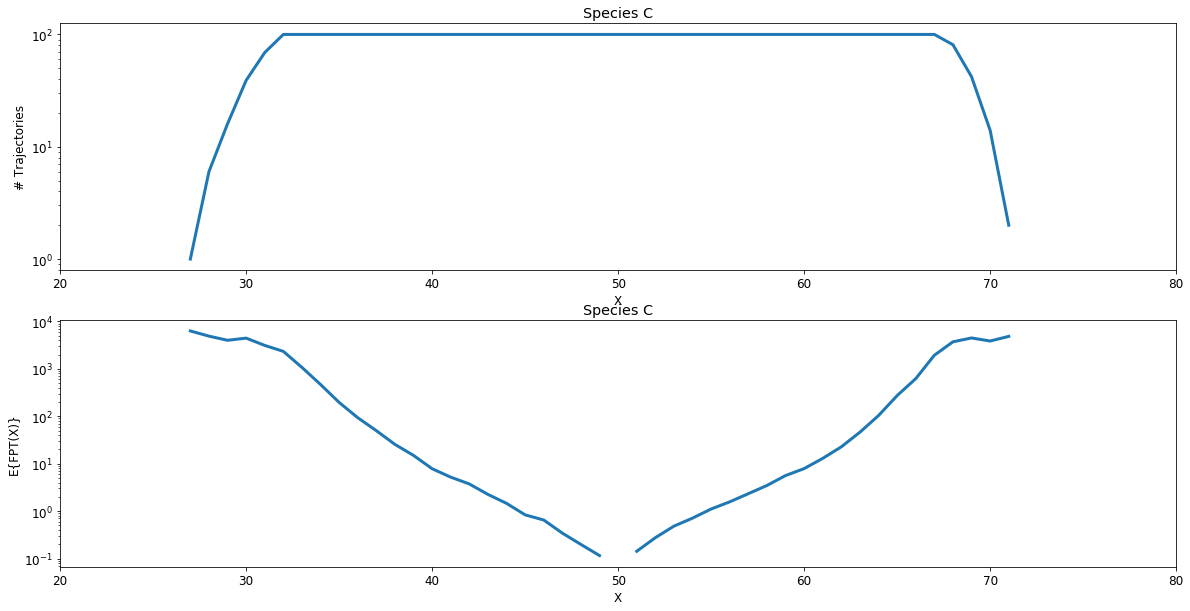

In [3]:
# Plot the mean first passage times for species 5.
dirname="data/1"
filename="%s/bimolecular_with_fpt.lm"%dirname
fp = h5py.File(filename, "r")
replicates=fp["/Simulations"].keys()
counts=None
times=None
allCounts = np.zeros((101,), dtype=double)
allTimes = np.zeros((101,), dtype=double)
for replicate in replicates:
    counts=np.array(fp["/Simulations/%s/FirstPassageTimes/05/Counts"%replicate], dtype=double)
    times=np.array(fp["/Simulations/%s/FirstPassageTimes/05/Times"%replicate], dtype=double)
    start = int(counts[0])
    end = start+counts.shape[0]
    allCounts[start:end] += 1    
    allTimes[start:end] += times
allTimes /= allCounts
matplotlib.rcParams.update({'font.size': 12, "figure.figsize": (20,10)})
ax=plt.subplot(2,1,1)
plt.plot(np.arange(0,len(allCounts), dtype=double),allCounts, **plotStyles)
ax.set_yscale('log'); xlim([20,80]); xlabel('X'); ylabel('# Trajectories'); title("Species C")
ax=plt.subplot(2,1,2)
plt.plot(np.arange(0,len(allCounts), dtype=double),allTimes, **plotStyles)
ax.set_yscale('log'); xlim([20,80]); xlabel('X'); ylabel('E{FPT(X)}'); title("Species C")
pass

### Performance comparison
Generate the input files and output the commands to run the simulations.

In [54]:
%%bash
dirname=data/perf.99.latest
filename=${dirname}/bimolecular_with_fpt.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} bimolecular_with_fpt.sbml
lm_setp ${filename} writeInterval=1e4 maxTime=1e5 "fptTrackingList=2,5"

lm_sbml_import v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group, University of Illinois at Urbana-Champaign.
Copyright (C) 2012-2016 Roberts Group, Johns Hopkins University.


Done.
lm_setp v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group,
University of Illinois at Urbana-Champaign.

Setting parameters in simulation file data/perf.99.latest/bimolecular_with_fpt.lm:
fptTrackingList=2,5
maxTime=1e5
writeInterval=1e4
Done.


In [56]:
%%bash
dirname=data/perf.99.latest
filename=${dirname}/bimolecular_with_fpt.lm
echo "Execute the following command in `pwd`:"
echo 'for replicate in `seq -f "%g" 0 10`; do'
echo "echo Running \${replicate};"
#echo "hostname=\`hostname\`"
#echo "lmesPrefix=/share/git/LatticeMicrobesES/build/"
echo "hostname=barkeri"
echo "lmesPrefix="
#echo "hostname=marcc"
#echo "lmesPrefix=/home-2/erober32@jhu.edu/share/git/LatticeMicrobesES/build-icc/"
#echo "\${lmesPrefix}lmes -r 1-16 -f ${filename} -c 2 -gr 0 -ff null -sl lm::cme::GillespieDSolver| tee ${filename}.\${hostname}.\${replicate}.log";
echo "\${lmesPrefix}lmes -r 1-16 -f ${filename} -c 2 -gr 0 -ff null -sl lm::avx::GillespieDSolverAVX| tee ${filename}.\${hostname}.\${replicate}.log";
echo 'done;'

Execute the following command in /Users/eroberts/Work/Lab/Git/LatticeMicrobesES/regression/bimolecular_with_fpt:
for replicate in `seq -f "%g" 0 10`; do
echo Running ${replicate};
hostname=barkeri
lmesPrefix=
${lmesPrefix}lmes -r 1-16 -f data/perf.99.latest/bimolecular_with_fpt.lm -c 2 -gr 0 -ff null -sl lm::avx::GillespieDSolverAVX| tee data/perf.99.latest/bimolecular_with_fpt.lm.${hostname}.${replicate}.log
done;


In [60]:
# Extract the timing data.
datadir="data"
timingData={}
testNumberMap={}
regex0 = re.compile("perf\.(\d+).(\S+)")
regex1 = re.compile("\.lm\.([^\.]+)\.(\d+)\.log")
regex2 = re.compile("Finished .+ seconds \((\S+) steps/second\)")
for dirname in os.listdir(datadir):
    testName = None
    m = regex0.search(dirname)
    if m != None:
        testNumber = m.group(1)
        testName = m.group(2)
        testNumberMap[testNumber] = testName
    if testName is not None:
        for logname in os.listdir(datadir+"/"+dirname):
            m = regex1.search(logname)
            if m != None:
                host=m.group(1)
                replicate=int(m.group(2))
                with open(datadir+"/"+dirname+"/"+logname) as f:
                    for line in f:
                        m = regex2.search(line)
                        if m != None:
                            if host not in timingData:
                                timingData[host]={}
                            if testName not in timingData[host]:
                                timingData[host][testName]=[]
                            timingData[host][testName].append(double(m.group(1)))
                            break

[17564545.454545453, 14604545.454545455, 27556363.636363637, 24701818.181818184]


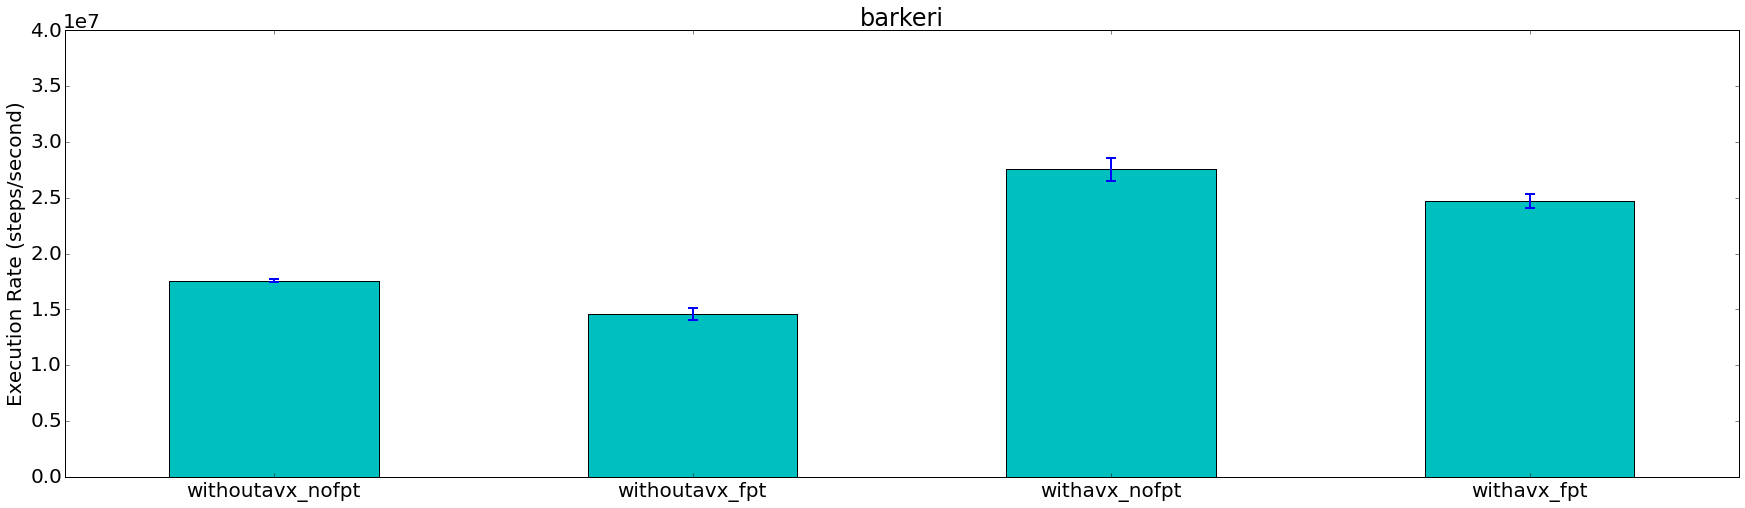

In [61]:
# Plot the timing data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (30,8)})
hosts = timingData.keys()
hosts.sort()
testNumbers = testNumberMap.keys()
testNumbers.sort()
for i,host in enumerate(hosts):
    times=[]
    timesErr=[]
    testNames=[]
    for testNumber in testNumbers:
        testName = testNumberMap[testNumber]
        if testName in timingData[host]:
            times.append(mean(timingData[host][testName]))
            timesErr.append(std(timingData[host][testName]))
            testNames.append(testName)
    plt.subplot(len(hosts),1,i+1)
    
    plt.bar(arange(0,len(testNames))+0.25,times,width=0.5,yerr=timesErr, color='c', error_kw={"elinewidth":2,"capsize":5,"capthick":2})
    plt.ylabel('Execution Rate (steps/second)')
    plt.xticks(arange(0,len(testNames))+0.5, testNames)
    plt.ylim([0,4e7])
    plt.title(host)
    print times
pass